<a href="https://colab.research.google.com/github/cyuancheng/NLP_Yelp_review/blob/master/NLP_1_twitter_Ichiro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Natural Language Processing and Sentiment Analysis for Twitter##


Data exploration of new toothpaste product in Twitter

In [0]:
import spacy #use NLP functions
from spacy import displacy
from textblob import TextBlob
import tweepy #tweeter python package
import re
import en_core_web_sm #(python -m spacy download en_core_web_lg) # pre-train model sm: small
import pandas as pd
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import string

from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

% matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [12]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'School_of_AI/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


###1. Data process and cleaning###
Get data of "Ichiro" from Twitter API and wrangle the data using python. The Spacy and Texbolb packages are used for NLP.

Firstly, Let's write functions to get data from Twitter API.

In [0]:
class connection_twitter():
    def __init__(self,consumer_key, consumer_secret, access_token, access_token_secret, keyword):
        auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
        auth.set_access_token(access_token, access_token_secret)
        self.api = tweepy.API(auth)
        self.key_word = [keyword]

        return None


#%%
# Structure the tweets

    def get_info(self,tweet):
        id = tweet.id
        text_ = tweet.full_text
        author = tweet.author
        date = tweet.created_at
        location = tweet.coordinates
        favorite_count = tweet.favorite_count

        user_favorite_count = tweet.user.favourites_count
        user_followers_count = tweet.user.followers_count
        user_location = tweet.user.location

        return id, text_, author, date, location, favorite_count, user_favorite_count, user_followers_count, user_location


    def get_texts(self):

        all_results = []
        for i in range(len(self.key_word)):
            tweets = tweepy.Cursor(self.api.search, q=self.key_word, lang = "en",tweet_mode='extended').items(100)
            result = [tweet for tweet in tweets]
            all_results.append(result)

        for i in range(len(all_results)):
            if i == 0:
                tweet_data = pd.DataFrame([self.get_info(tweet) for tweet in all_results[i]])

            else:
                tweet_data = pd.concat([pd.DataFrame([self.get_info(tweet) for tweet in all_results[i]]), tweet_data])

        tweet_data.columns = ['id', 'text_', 'author', 'date', 'location', 'favorite_count', 'user_favorite_count', 'user_followers_count', 'user_location']

        return tweet_data


Now, use keyword of "New Zealand" to pull data from Twitter API.

In [3]:
consumer_key = 'oxzQOYB3Yh1cTezTa0X9yYWaB'
consumer_secret = 'tL7HzTqiORDEvnzSq5ghsOwl9wl2ntlPT5Q8opdGMErltW1dr5'
access_token = '3579562937-XxUFCW12vuqHwjifqx0YTOAi8xzRKvIWPZsx5DV'
access_token_secret = '9b0WGTWIrSQZY7QAWtpXuZEkEKrKjKpKPcm70BFb9XrkD'

keyword = 'Ichiro'

twitter = connection_twitter(consumer_key,consumer_secret,access_token,access_token_secret,keyword)

data = twitter.get_texts()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
id                      100 non-null int64
text_                   100 non-null object
author                  100 non-null object
date                    100 non-null datetime64[ns]
location                0 non-null object
favorite_count          100 non-null int64
user_favorite_count     100 non-null int64
user_followers_count    100 non-null int64
user_location           100 non-null object
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 7.1+ KB


Briefly take a look at the data

In [17]:
data.head(5)

,id,text_,author,date,location,favorite_count,user_favorite_count,user_followers_count,user_location,Polarity,Subjectivity
0,1109639026577944577,RT @Mariners: #TBT to the day Ichiro put the r...,User(_api=<tweepy.api.API object at 0x7fc3d6f8...,2019-03-24 02:12:14,None,0,7306,124,NaN,0.0,0.0
1,1109638771677556736,RT @BattingStanceG: Gotta give Ichiro what he ...,User(_api=<tweepy.api.API object at 0x7fc3d6f8...,2019-03-24 02:11:13,None,0,13623,61,NaN,0.2,0.1
2,1109638730699046912,RT @11EdgarMartinez: Congratulations to Ichiro...,User(_api=<tweepy.api.API object at 0x7fc3d6f8...,2019-03-24 02:11:04,None,0,10547,437,Earth,0.9,0.9
3,1109638360937619462,RT @taro_f: Thank you so much Ichiro. The reas...,User(_api=<tweepy.api.API object at 0x7fc3d6f8...,2019-03-24 02:09:35,None,0,746,618,tokyo,0.2,0.2
4,1109637941234548736,"RT @MLB: Thank you, Ichiro.\n\nIchiro Suzuki w...",User(_api=<tweepy.api.API object at 0x7fc3d6f8...,2019-03-24 02:07:55,None,0,1483,140,NaN,0.0,0.0


In [0]:
#save file to Google Drive
data.to_csv(base_dir + 'export_twitter_ichiro.csv', index = None, header=True) #Don't forget to add '.csv' at the end of the path

Use TexBolb for the sentiment analysis in the "text_" column, and add "Polarity" and "Subjectivity" into the dataset

In [0]:
data['Polarity'] = [TextBlob(x).sentiment[0] for x in data['text_'] ]
data['Subjectivity'] = [TextBlob(x).sentiment[1] for x in data['text_'] ]

Next, we clean the data 
- replace empty data by nan
- groupby 'user_location'

In [26]:
data["user_location"].replace('', np.nan, inplace=True)
data1 = data.groupby('user_location').sum().sort_values(["Polarity"],ascending=True)
data1.head(5)

,id,favorite_count,user_favorite_count,user_followers_count,Polarity,Subjectivity
user_location,,,,,,
"Pasadena, CA",1109635088759676928,2,392,31,-0.56250,1.00000
千葉県,1109632014544568320,0,28992,225,-0.40000,0.40000
Taiwan,1109627602615046144,0,12761,208,-0.31250,0.68750
We Follow Back,1109626478222893056,0,1354,3335,-0.30000,0.50000
Downtown,5548145061532090368,6,9070,245,-0.15434,1.96684


###2. Plotting###
Make a plot to compare polarity betweeen different location around the world

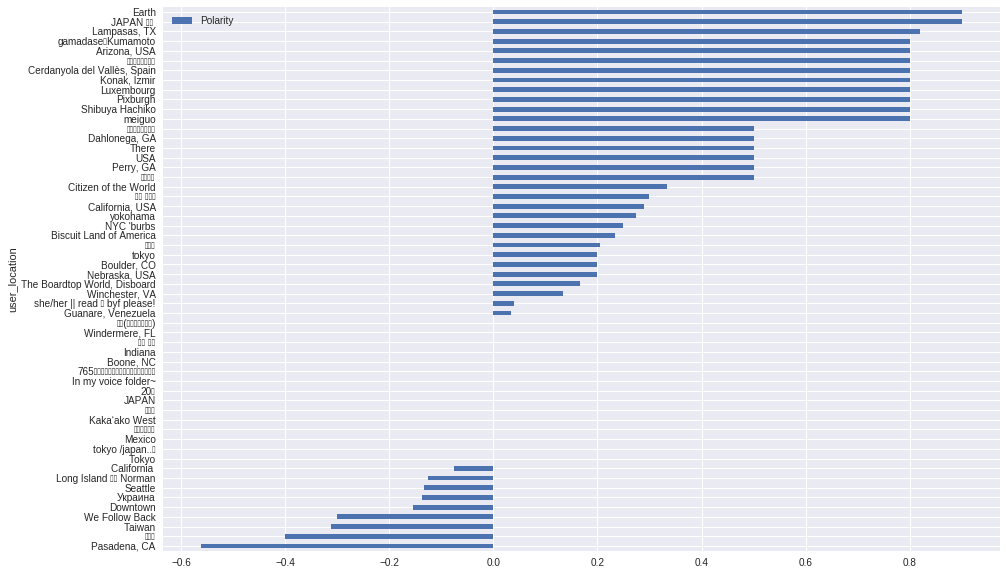

In [27]:
data1[['Polarity']].plot(kind='barh', figsize=(15, 10), legend=True)

In [28]:
print("statistics")
print("Positive: {0}" .format(len(data1[data1['Polarity']>0])))
print("Neutral: {0}" .format(len(data1[data1['Polarity']==0])))
print("Negative: {0}" .format(len(data1[data1['Polarity']<0])))

statistics
Positive: 32
Neutral: 15
Negative: 9


In [30]:
print(data['text_'][0])
print(data['Polarity'][0])
print(data['Subjectivity'][0])

#print(data['user_location'][5])
#data.iloc[64,:]

RT @Mariners: #TBT to the day Ichiro put the rest of the league on notice.

#ThanksIchiro https://t.co/qwJ2fWYjVn
0.0
0.0


###3. Data process for wordcloud###
Try wordcloud
pre-process text column
postive / negative 

In [44]:
import spacy
print('spaCy Version: %s' % (spacy.__version__))
spacy_nlp = spacy.load('en_core_web_sm')

spaCy Version: 2.0.18


In [45]:
# print stop words from spacy
stopwords = spacy.lang.en.stop_words.STOP_WORDS
print(stopwords)

{'mine', 'almost', 'that', 'serious', 'nothing', 'becoming', 'same', 'many', 'six', 'somehow', 'two', 'put', 're', 'anything', 'between', 'just', 'hence', 'during', 'yourselves', 'somewhere', 'already', 'mostly', 'something', 'eight', 'if', 'not', 'itself', 'alone', 'call', 'too', 'unless', 'they', 'us', 'twenty', 'bottom', 'side', 'wherein', 'before', 'using', 'enough', 'beyond', 'four', 'nobody', 'be', 'onto', 'towards', 'name', 'never', 'none', 'regarding', 'toward', 'thru', 'show', 'we', 'himself', 'our', 'amount', 'ours', 'eleven', 'least', 'whence', 'by', 'for', 'within', 'third', 'top', 'in', 'their', 'hereafter', 'at', 'all', 'fifteen', 'where', 'might', 'is', 'does', 'several', 'further', 'about', 'an', 'front', 'it', 'anyhow', 'hereupon', 'sixty', 'also', 'whether', 'both', 'become', 'three', 'anyone', 'either', 'latterly', 'meanwhile', 'ca', 'made', 'which', 'still', 'you', 'your', 'less', 'a', 'besides', 'can', 'fifty', 'go', 'indeed', 'once', 'above', 'but', 'to', 'there',

In [0]:
# check stop words
w = 'https'
spacy_nlp.vocab[w].is_stop = True
#nlp.vocab['christchurch'].is_stop = True


In [0]:
#len(data['text_'])
data.head()

,id,text_,author,date,location,favorite_count,user_favorite_count,user_followers_count,user_location,Polarity,Subjectivity
0,1106621272023359490,RT @WaqarHBhatti2: World media calls him shoot...,User(_api=<tweepy.api.API object at 0x7f19758d...,2019-03-15 18:20:45,None,0,227,459,الرياض,-0.200000,0.000000
1,1106621272019087360,RT @LisaSmith4680: Are you dumb or are you jus...,User(_api=<tweepy.api.API object at 0x7f19758d...,2019-03-15 18:20:45,None,0,76452,2592,United States,-0.607727,0.750909
2,1106621272018939904,RT @OCASI_Policy: Our thoughts are with the fa...,User(_api=<tweepy.api.API object at 0x7f19758d...,2019-03-15 18:20:45,None,0,3990,3650,"Toronto, Ontario",-0.331818,0.727273
3,1106621272002306048,Praying today for neighbors at the Islamic Cen...,User(_api=<tweepy.api.API object at 0x7f19758d...,2019-03-15 18:20:45,None,0,3116,2171,"Wheaton and Chicago, mostly",0.084091,0.513636
4,1106621271821869056,RT @getongab: 4chan has reportedly been blocke...,User(_api=<tweepy.api.API object at 0x7f19758d...,2019-03-15 18:20:45,None,0,30663,1031,NaN,0.136364,0.454545


clean text in the "text_" column

In [0]:
data['text_clean'] = data['text_']

In [35]:
data['text_'][1].split(' ')

['RT',
 '@BattingStanceG:',
 'Gotta',
 'give',
 'Ichiro',
 'what',
 'he',
 'wants:',
 '@Rockies',
 'Dante',
 'BIchette.',
 'https://t.co/4bcguQWgsm']

Remove punctuations, double space; put text in lower case

In [0]:
data['text_clean'] = data['text_clean'].apply(lambda x: re.sub('[!@#$:).;,?&]', '', x.lower()))
data['text_clean'] = data['text_clean'].apply(lambda x: re.sub('  ', ' ', x))

In [0]:
# remove URLs, other words, and twitter handles

for i in range(len(data['text_'])):

    data['text_clean'][i] = " ".join([word for word in data['text_clean'][i].split(' ')
                                    if 'http' not in word \
                                      and '@' not in word \
                                      and '#' not in word\
                                      and '\n' not in word\
                                      and 'rt' not in word])


In [39]:
data['text_clean']

0     mariners tbt to the day ichiro put the rest of...
1     battingstanceg gotta give ichiro what he wants...
2     congratulations to ichiro for an incredible ca...
3     taro_f thank you so much ichiro the reason i c...
4     mlb thank you suzuki will retire after a 19-ye...
5     espn one final goodbye for a tips his cap to t...
6     darenw i got a ton of requests for this a time...
7     positiveichiro its okay ichiro im doing a lot ...
8             mlbstats it’s been quite a run for ichiro
9     marlins congratulations on an incredible caree...
10    angel_rocks99 one cut of the dead- shin'ichirô...
11    battingstanceg gotta give ichiro what he wants...
12       pitchingninja ichiro and dee gordon  no bowhug
13                __234scars_____ if you're sdv twitter
14       pitchingninja ichiro and dee gordon  no bowhug
15                      ogecebel you are proud of japan
16    heyloveradio i will see you tonight in hey lov...
17               mlb yep ichiro’s still got it 💪

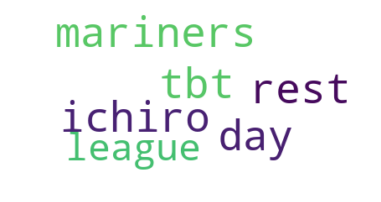

In [48]:
mpl.rcParams['figure.figsize']=(6.0,4.0)    #(6.0,4.0)
mpl.rcParams['font.size']=8               #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['figure.subplot.bottom']=.1 

#wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(data[][0])


stopwords1 = set(stopwords)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords1,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(data['text_clean'][0])

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


#print(wordcloud)
#fig = plt.figure(1)
#fig.savefig("word1.png", dpi=900)

In [49]:
print(data['text_clean'][0])

mariners tbt to the day ichiro put the rest of the league on


Print postive word by wordcloud

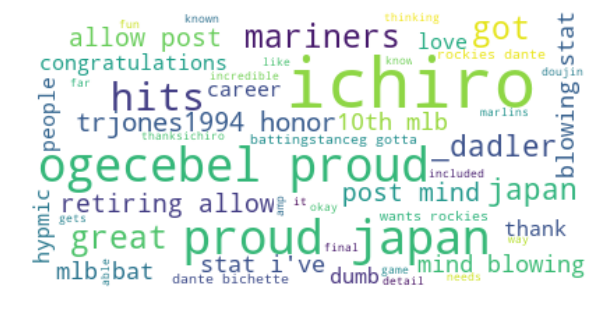

In [50]:
text_pro = ''
for text in data[data['Polarity']>0]['text_clean']:
  
  text_pro = text_pro + ' ' + text

#text_pro
stopwords1 = set(stopwords)

wordcloud = WordCloud(max_font_size=50, max_words=50, stopwords=stopwords1, background_color="white").generate(text_pro)

plt.figure( figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
  


print negative words by wordcloud

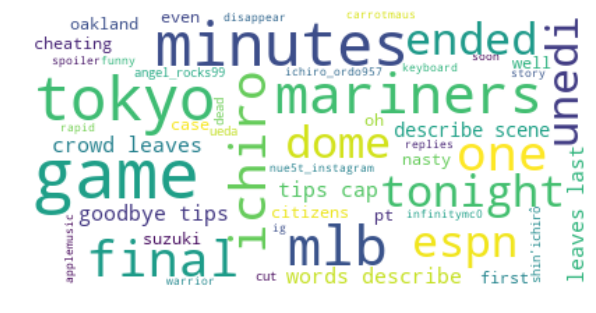

In [51]:
text_negative = ''
for text in data[data['Polarity']<0]['text_clean']:
  
  #if text not in spacy.lang.en.stop_words.STOP_WORDS:
  text_negative = text_negative + ' ' + text


text_negative

wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(text_negative)

plt.figure( figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
  
 

In [0]:
text_negative

' isn\'t crunching ice bad for your teeth makes you wonder about their brand/choices sf tv commercial \'ice cruncher\' featuring luke wilson - ispottv white with green tea mint are you a little extra so am i so is my i recently tried out the whitening ad domoreforyourwholemouth ccbraves it’s happened to me a couple of times my 40 ounce both fights cavities and clearly will take down a plain always a regional too the other day i was in a bad mood so my mom offered to buy me some yeah mom some is gonna fix all my problems new post cvs mouthwash 500ml 99c/u *reg 549c/u* [termina [03/16/19] commercials representing "i\'m an asshole" and people just have to deal with my bad habits doesn\'t really spread a positive message don\'t find humor in making people vasan_bala vicky_donorr many asking for to make the opposite side of in all the tweets they haven\'t watch the advt intolerance and annoying the politicians made the people for their benefit i am sorry for those who are educated but still